## Monte Carlo Integration

Using MC integration, verify that $$\int{ x^{3} exp \ \big( -\frac{x^{2}}{2 \sigma^{2}} \big) } = 2 \sigma^{4}$$

> Does the result converge with the number of samples?

I transform the argument of the integral into a product of two functions: a normalized p.d.f *p(x)* and another arbitrary function *f(x)*: to do this, I make use of the the definition of a normalized gaussian distribution, i.e. $\frac{1}{\sqrt{2 \pi \sigma^{2}}} \ exp \ \big( -\frac{x^{2}}{2 \sigma^{2}} \big)$ thus I can split the integrand into two functions:

$$f(x) = \frac{1}{2} \ x^{3} \ \sqrt{2 \pi \sigma^{2}} \ \ \ \leftrightarrow \ \ \ p(x) = 2 \ \frac{1}{\sqrt{2 \pi \sigma^{2}}} \ exp \ \big( -\frac{x^{2}}{2 \sigma^{2}} \big)$$

Notice that a $2$ factor must be added to re-normalize $p(x)$, while $f(x)$ incorporates its $\frac{1}{2}$ 'counterpart'.

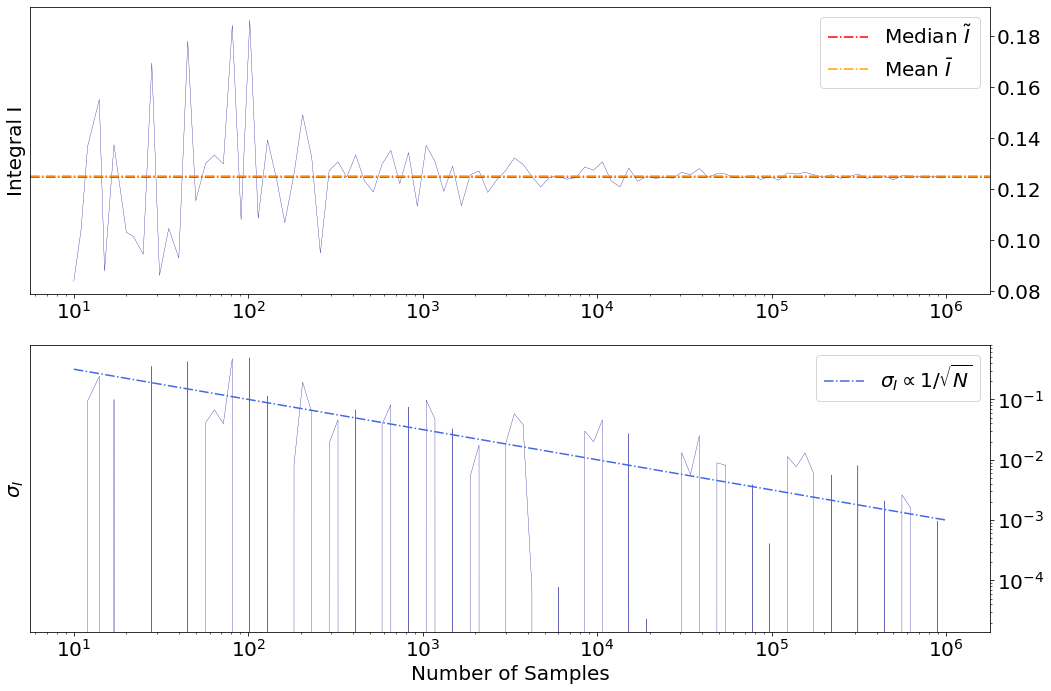

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 20

# An arbitrary value of sigma is picked
sigma = 0.5

# Define f(x) as stated above
def f(x): 
    y = 0.5*np.sqrt(2*np.pi*sigma**2) * x**3
    return y

# Define an algorithm to sample the data and compute the integral
# The gaussian is symmetric, thus the absolute value of the sample is taken
# and no rv is discarded, without alterations in the sampling
def alg(N):
    sample = np.random.normal(0, sigma, N)
    sample = np.abs(sample)
    integral = np.sum(f(sample))/N
    return sample, integral

# Setting up the different samplings to plot, from 1e1 to 1e6
L = 100
num = np.logspace(1,6,L,dtype=int)
res = np.zeros(L)
sam = np.empty(L,dtype=np.ndarray)

i = 0
for N in num:
    sam[i], res[i] = alg(N)
    i+=1
    
fig, axs = plt.subplots(2,1)
ax = axs.ravel()
     
ax[0].plot(num,res,ls='-', lw=0.3, c='darkblue')
ax[0].set_xscale('log')
ax[0].axhline(np.median(res),c='red',ls='-.', label=r'Median $\tilde{I}$')
ax[0].axhline(np.mean(res),c='orange',ls='-.', label=r'Mean $\bar{I}$')
ax[0].legend()
ax[0].set_ylabel('Integral I')
ax[0].yaxis.tick_right()

true = 2*sigma**4
tag = r'$\sigma_{I} \propto 1/\sqrt{N}$'
ax[1].plot(num, (res-true)/true, c='darkblue', lw=0.3)
ax[1].plot(num, num**(-0.5), ls='-.', c='royalblue', label=tag)
ax[1].loglog()
ax[1].legend()
ax[1].set_xlabel('Number of Samples')
ax[1].set_ylabel(r'$\sigma_{I}$')
ax[1].yaxis.tick_right()

fig.tight_layout()

The result does indeed converge to the actual value of $2 \sigma^{4}$. For low values of N, there is a clear fluctuation from the "true" value of $I$, which is rapidly absorbed with N increasing.

Meanwhile, the integration error is proportional to $1/\sqrt{N}$, as expected. 

An extra observation on the robustness of the median can be made, when the number of iterations between $N_{min}$ and $N_{max}$ decreases: if $L$ is set to $\sim10$, for example, the values of $\tilde{I}$ and $\bar{I}$ can differ drastically.

> For a given N, how are the results distributed? Try to fit them with a parametric model.

I use the previously constructed algorithm to repeatedly sample a distribution of N samples, and fit it with a gaussian curve.

(0.08992740310356273, 0.160127671803377)

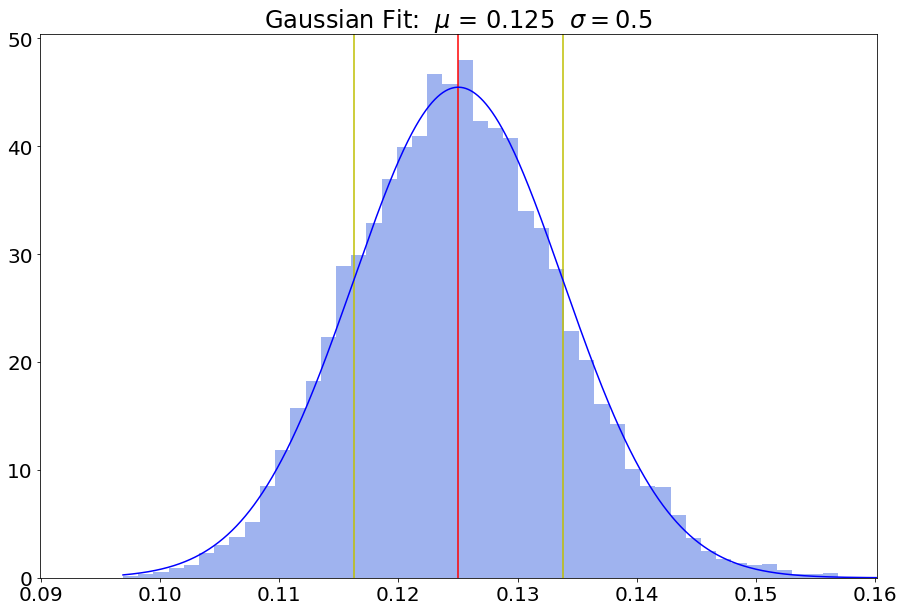

In [5]:
def Multiple_Samplings( N, cycles ):
    II = np.empty(cycles)
    for i in range(cycles):
        sample, integral = alg(N)
        II[i] = integral
    return II

N = 1000
cycles = 10000
II = Multiple_Samplings(N, cycles)

# Find Mean and RMS
from scipy import stats
mu, rms = stats.norm.fit(II)

plt.hist(II, bins=50, density=True, color='royalblue', alpha=0.5)
plt.axvline(mu, c='r')
plt.axvline(mu-rms, c='y')
plt.axvline(mu+rms, c='y')

def gauss(x,mu,s):
    y = np.exp(-(x-mu)**2/(2*s**2))*(np.sqrt(2*np.pi*s**2))**(-1)
    return y

X = np.linspace(np.min(II),np.max(II),len(II))
plt.plot(X, gauss(X,mu,rms), c='b')
header = 'Gaussian Fit:  $\mu$ = ' + str(np.round(mu,3)) + '  $\sigma = $' + str(np.round(sigma,3))
plt.title(header)
plt.xlim([mu-4*rms,mu+4*rms]) #JustAesthetics

"As expected", there is no trouble in fitting the curve with a gaussian: there is a reason for it, which can be found in the Central Limit Theorem.

> How does the distribution change if N increases?

I set up a custom color palette to identify the evolution of the process and iterate the algorithm above.

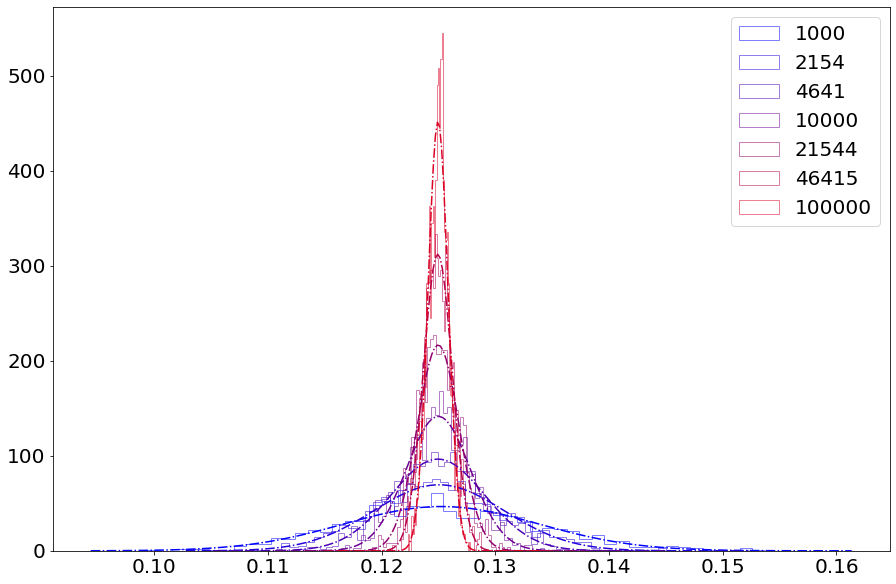

In [6]:
# Setting up a custom palette: 
# I trust StackOverflow for a bunch of code lines, but I customized the function a little.

def Redshift_Colors( L ):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcol
    import matplotlib.cm as cm

    # Make a user-defined colormap.
    cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])

    # Make a normalizer that will map the values from
    # [0,L] -> [0,1].
    cnorm = mcol.Normalize(vmin=0,vmax=L)

    # Turn these into an object that can be used to map values to colors and
    # can be passed to plt.colorbar().
    cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
    cpick.set_array([])

    colors = []
    for c in range(L):
        colors.append(cpick.to_rgba(c))
    return colors

# Define a normalized gaussian function
def gauss(x,mu,s):
    y = np.exp(-(x-mu)**2/(2*s**2))*(np.sqrt(2*np.pi*s**2))**(-1)
    return y

# Iterate on a range of N values to see what happens.
v = np.logspace(3,5,7,dtype=int)
colors = Redshift_Colors(len(v))
for N,col in zip(v,colors):
    II = Multiple_Samplings(N, 1000)
    plt.hist(II, bins=50, density=True, histtype='step', label=N, color=col, alpha=0.5)
    mu = np.mean(II)
    rms = np.std(II)
    
    X = np.linspace(0.95*np.min(II),1.05*np.max(II),100)
    plt.plot(X, gauss(X,mu,rms), color=col, ls='-.')
    
plt.legend()

As expected from the CLT, with N increasing the distribution becomes "more and more gaussian", and shrinks around the mean value. 